In [1]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:95% !important; }div.output_wrapper .output { padding-left: 14px; }</style>"))

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()


import pandas as pd

Using TensorFlow backend.


In [3]:
train_orig = pd.read_csv('data/mnist/train.csv')
test_orig = pd.read_csv('data/mnist/test.csv')

train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1]:
def show_plots(data, x = 0, y = 690, z = 1699, c = 420) :
    plt.figure(1)
    plt.subplot(221)
    plt.imshow(data[x])

    plt.subplot(222)
    plt.imshow(data[y])

    plt.subplot(223)
    plt.imshow(data[z])

    plt.subplot(224)
    plt.imshow(data[c])
    plt.show()

In [4]:
test_orig.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    train_orig.drop("label", axis = 1), train_orig["label"], test_size=0.2, random_state=0)

In [28]:
# create 'label' column in test dataset; rearrange so that columns are in the
# same order as in train
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]

In [29]:
# combine original train and test sets
combined = pd.concat([train_orig, test_orig], ignore_index = True)

combined.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Hold out 5000 random images as a validation/test sample
valid = combined.sample(n = 5000, random_state = 555)
train = combined.loc[~combined.index.isin(valid.index)]

# free up some space and delete test and combined
#del train_orig, test_orig, combined

valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
15545,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24241,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10099,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57209,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2947,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# X's
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
#X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
#X_valid = X_valid.values.reshape(-1,28,28,1)

def reshape(input):
    x = input.astype('float32') / 255.
    x = x.drop("label", axis = 1)
    x = x.values.reshape(-1, 28, 28, 1)
    return x

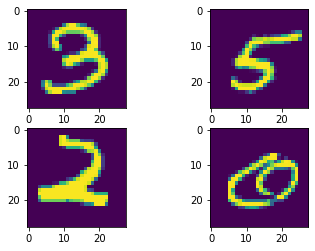

In [10]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, UpSampling2D

In [23]:
# the modified model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

input_dim = X_train.shape[1]
encoding_dim = 100

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(input_dim / 2), activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(input_dim / 4), activation=tf.keras.layers.LeakyReLU(alpha=0.01))(encoder)
encoder = Dense(int(input_dim / 8), activation="tanh")(encoder)
latent_space = Dense(encoding_dim, activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                name = "latent-space")(encoder) # the bottleneck layer
decoder = Dense(int(input_dim / 8), activation="tanh")(latent_space)
decoder = Dense(int(input_dim / 4), activation=tf.keras.layers.LeakyReLU(alpha=0.01))(decoder)
decoder = Dense(int(input_dim / 2), activation='tanh')(decoder)
output_layer = Dense(input_dim, activation="tanh")(decoder)
autoencoder = Model(inputs=input_layer, outputs=output_layer)

In [24]:
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_8 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_9 (Dense)              (None, 98)                19306     
_________________________________________________________________
latent-space (Dense)         (None, 100)               9900      
_________________________________________________________________
dense_10 (Dense)             (None, 98)                9898      
_________________________________________________________________
dense_11 (Dense)             (None, 196)              

In [25]:
import tensorflow_addons as tfa
from tensorflow.keras import metrics

autoencoder.compile(optimizer='adam', 
                    loss = "mse",
                    metrics = [
                        metrics.RootMeanSquaredError(name='rms'),
                        metrics.MeanAbsoluteError(name='mae')
                        ]
                   )
checkpointer = ModelCheckpoint(filepath="model.z1",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=20,
                    batch_size=32,
                    shuffle=True, 
                    validation_data=(X_valid, X_valid),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/20
   1/2032 [..............................] - ETA: 0s - loss: 0.1193 - rms: 0.3299 - mae: 0.1702WARNING:tensorflow:From C:\Users\Q514216\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2028/2032 [============================>.] - ETA: 0s - loss: 0.0255 - rms: 0.1447 - mae: 0.0811WARNING:tensorflow:From C:\Users\Q514216\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
I

In [32]:
encoder_model = Model(input_layer, latent_space)
embedded_data = encoder_model.predict(combined.drop(['label'], axis = 1)) # does the predict function shuffle the data?
labels = combined["label"]

In [79]:
preds = autoencoder.predict(combined.drop(["label"], axis = 1))
preds = pd.DataFrame(preds)
preds.columns = combined.drop(["label"], axis = 1).columns
preds.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,-0.000504,0.006437,0.010570,0.000588,-0.001513,0.002166,0.001590,-0.002187,-0.005402,-0.005563,...,-0.004467,-0.016036,0.009360,0.008643,-0.001989,0.010728,0.010205,0.004107,0.007890,0.004908
1,0.000752,-0.001061,-0.001617,-0.007897,-0.006838,-0.007515,-0.005053,0.012368,-0.027115,-0.004428,...,-0.031803,-0.007139,-0.014197,-0.012121,-0.003493,0.006001,-0.004841,-0.005192,-0.001379,-0.001212
2,0.002498,0.003867,-0.001438,0.001118,-0.000908,-0.000631,0.000469,0.007010,0.003476,-0.003237,...,0.005204,0.011552,-0.000944,0.006159,0.010664,0.001621,0.001372,-0.005413,0.001084,0.021673
3,0.004448,-0.000451,0.001942,-0.003430,-0.004882,-0.005470,-0.001951,0.005591,0.007286,0.000811,...,0.023770,0.015893,0.007723,0.003694,-0.006159,0.006335,0.004815,-0.008678,-0.005392,0.017797
4,0.000438,-0.007073,-0.002039,-0.008068,0.019859,-0.002888,-0.004327,0.001684,-0.010822,0.003792,...,-0.015526,0.010528,-0.002270,0.007040,0.006697,-0.010718,-0.004595,0.000125,-0.006952,0.002545


In [34]:
import io
embedding = tf.Variable(tf.stack(embedded_data, axis=0), trainable=False, name='embedding')

out_v = io.open('latent_space_mnist.tsv', 'w', encoding='utf-8')
out_m = io.open('labels_mnist.tsv', 'w', encoding='utf-8')

for index, word in enumerate(labels): 
    vec = embedding[index-1] 
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(str(word) + "\n")

out_v.close()
out_m.close()

KeyboardInterrupt: 

In [71]:
y = reshape(combined)
y.shape

(70000, 28, 28, 1)

In [73]:
embedded_data.shape

(70000, 100)

In [84]:
x = preds.astype('float32') / 255.
#x = x[:, 1:]
x = x.values.reshape(-1, 28, 28, 1)

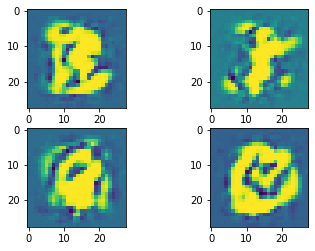

In [85]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x[13][:,:,0])

plt.subplot(222)
plt.imshow(x[690][:,:,0])

plt.subplot(223)
plt.imshow(x[2375][:,:,0])

plt.subplot(224)
plt.imshow(x[42013][:,:,0])
plt.show()

In [86]:
import os
from tensorboard.plugins import projector

# Set up a logs directory, so Tensorboard knows where to look for files
log_dir = 'mnist_autoencoder/logs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


# Create a checkpoint from embedding, the filename and key are
# name of the tensor.

checkpoint = tf.train.Checkpoint(embedding=embedding)
CHECKPOINT_FILE = os.path.join(log_dir, "embedding.ckpt")
checkpoint.save(CHECKPOINT_FILE)

'mnist_autoencoder/logs\\embedding.ckpt-1'

In [87]:
# Set up config
config = projector.ProjectorConfig()
##config.model_checkpoint_path = CHECKPOINT_FILE # doesn't help
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "check_the_name"
embedding.metadata_path = os.path.join(log_dir, 'labels_mnist.tsv')

writer = tf.summary.create_file_writer(log_dir)
projector.visualize_embeddings(log_dir, config)

In [88]:
import tensorboard
%reload_ext tensorboard

In [95]:
#%tensorboard --logdir logs/imdb-example/ --host localhost #--port=7010
#%tensorboard --logdir data/tensorboard_ticket/vecs.tsv --host localhost --port=7080

%tensorboard --logdir /logs/ --host localhost --port=1090

Reusing TensorBoard on port 1090 (pid 10756), started 0:02:42 ago. (Use '!kill 10756' to kill it.)

In [48]:
# Encoder
# does it make sense to use dropout in an autoencoder???
inputs = tf.keras.layers.Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPool2D()(x)
#x = tf.keras.layers.Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPool2D()(x)

In [49]:
# Decoder
x = Conv2D(32, 3, activation='relu', padding='same')(encoded)
x = UpSampling2D()(x)
#x = tf.keras.layers.Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)